In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'spotfy:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4978748%2F8374039%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240529%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240529T015046Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D129e74c187fe4993ed3b9cc668f08896d0b985ddba4ee91a0438a24c75e434cd62ac6aa55ae24f43b6eb06ec1677cad9347aa841651de4ec5a212b2c793bf9aaa89b291565dff0f3debbbf4bc78bda5ef4c201987cd7488ff350ee6b56ab84498e2e2238c3960bf6c2591e590c296f472c80d2527d25bb5a4a6229212e5c4b17e71988b23ad15bfda7a10c512edcaec3b4e3c74a9187f1af7674be2bbb4f84ca0a86df27b392b1fe69134dc7dae9ac99820126b9d59ceaf40d006539e629467d8dffd3f3ddc3bc702c0ad8149ae8467b8a5d8bc91f20b5b420c2a6c2c14aefc849c7a94e722965d607890f30b89e40895a34cf70642ba9d082e421689b4f7352'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 48205 bytes downloaded
Downloaded and uncompressed: spotfy
Data source import complete.


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated*", category=FutureWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spotfy/Popular_Spotify_Songs.csv


In [3]:
# Load the data
with open("/kaggle/input/spotfy/Popular_Spotify_Songs.csv", "rb") as f:
    encoding = chardet.detect(f.read())["encoding"]

data = pd.read_csv("/kaggle/input/spotfy/Popular_Spotify_Songs.csv", encoding=encoding)

In [4]:
data.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


# Fields and Data Types 🎵:
This table contains information on music tracks and their performance across various platforms. It consists of the following columns:

* Track Name: The name of the track, represented as an object.
* Artist(s) Name: The name(s) of the artist(s) who created the track, represented as an object.
* Artist Count: The number of artists associated with the track, represented as an integer.
* Released Year: The year when the track was released, represented as an integer.
* Released Month: The month when the track was released, represented as an integer.
* Released Day: The day when the track was released, represented as an integer.
* In Spotify Playlists: Indicates whether the track is included in Spotify playlists, represented as a boolean.
* In Spotify Charts: Indicates whether the track is present in Spotify charts, represented as a boolean.
* Streams: The total number of streams the track has accumulated, represented as an integer.
* In Apple Playlists: Indicates whether the track is included in Apple Music playlists, represented as a boolean.
* In Apple Charts: Indicates whether the track is present in Apple Music charts, represented as a boolean.
* In Deezer Playlists: Indicates whether the track is included in Deezer playlists, represented as a boolean.
* In Deezer Charts: Indicates whether the track is present in Deezer charts, represented as a boolean.
* In Shazam Charts: Indicates whether the track is present in Shazam charts, represented as a boolean.
* BPM: Beats per minute - a measure of tempo in music, represented as an integer.
* Key: The musical key in which the track is composed, represented as an object.
* Mode: Indicates whether the track is in a major or minor key, represented as an object.
* Danceability: A measure of how suitable a track is for dancing, represented as a float.
* Valence: The musical positiveness conveyed by a track, represented as a float.
* Energy: The perceived energy of a track, represented as a float.
* Acousticness: A measure of how acoustic a track is, represented as a float.
* Instrumentalness: A measure of whether a track contains vocals, represented as a float.
* Liveness/Speechiness: A measure of presence of live elements or spoken words in a track, represented as a float.

In [5]:
# Display information about the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

In [6]:
# Descriptive statistics
print(data.describe())

       artist_count  released_year  released_month  released_day  \
count    953.000000     953.000000      953.000000    953.000000   
mean       1.556139    2018.238195        6.033578     13.930745   
std        0.893044      11.116218        3.566435      9.201949   
min        1.000000    1930.000000        1.000000      1.000000   
25%        1.000000    2020.000000        3.000000      6.000000   
50%        1.000000    2022.000000        6.000000     13.000000   
75%        2.000000    2022.000000        9.000000     22.000000   
max        8.000000    2023.000000       12.000000     31.000000   

       in_spotify_playlists  in_spotify_charts  in_apple_playlists  \
count            953.000000         953.000000          953.000000   
mean            5200.124869          12.009444           67.812172   
std             7897.608990          19.575992           86.441493   
min               31.000000           0.000000            0.000000   
25%              875.000000          

In [7]:
data.columns

Index(['track_name', 'artist(s)_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')

# Handling missing data

In [8]:
# Missing data
print(data.isnull().sum())

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64


In [9]:
# Fill missing values
data['in_shazam_charts'].fillna(0, inplace=True)
data['key'].fillna('Unknown', inplace=True)

# Verify the data
print(data.isnull().sum())

track_name              0
artist(s)_name          0
artist_count            0
released_year           0
released_month          0
released_day            0
in_spotify_playlists    0
in_spotify_charts       0
streams                 0
in_apple_playlists      0
in_apple_charts         0
in_deezer_playlists     0
in_deezer_charts        0
in_shazam_charts        0
bpm                     0
key                     0
mode                    0
danceability_%          0
valence_%               0
energy_%                0
acousticness_%          0
instrumentalness_%      0
liveness_%              0
speechiness_%           0
dtype: int64


# EDA (Exploratory Data Analysis)

In [10]:
# Convert specific columns to numeric
data['streams'] = pd.to_numeric(data['streams'], errors='coerce')
data['in_deezer_playlists'] = pd.to_numeric(data['in_deezer_playlists'], errors='coerce')
data['in_shazam_charts'] = pd.to_numeric(data['in_shazam_charts'], errors='coerce')

<ipython-input-11-d8f4fc3c06cf>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


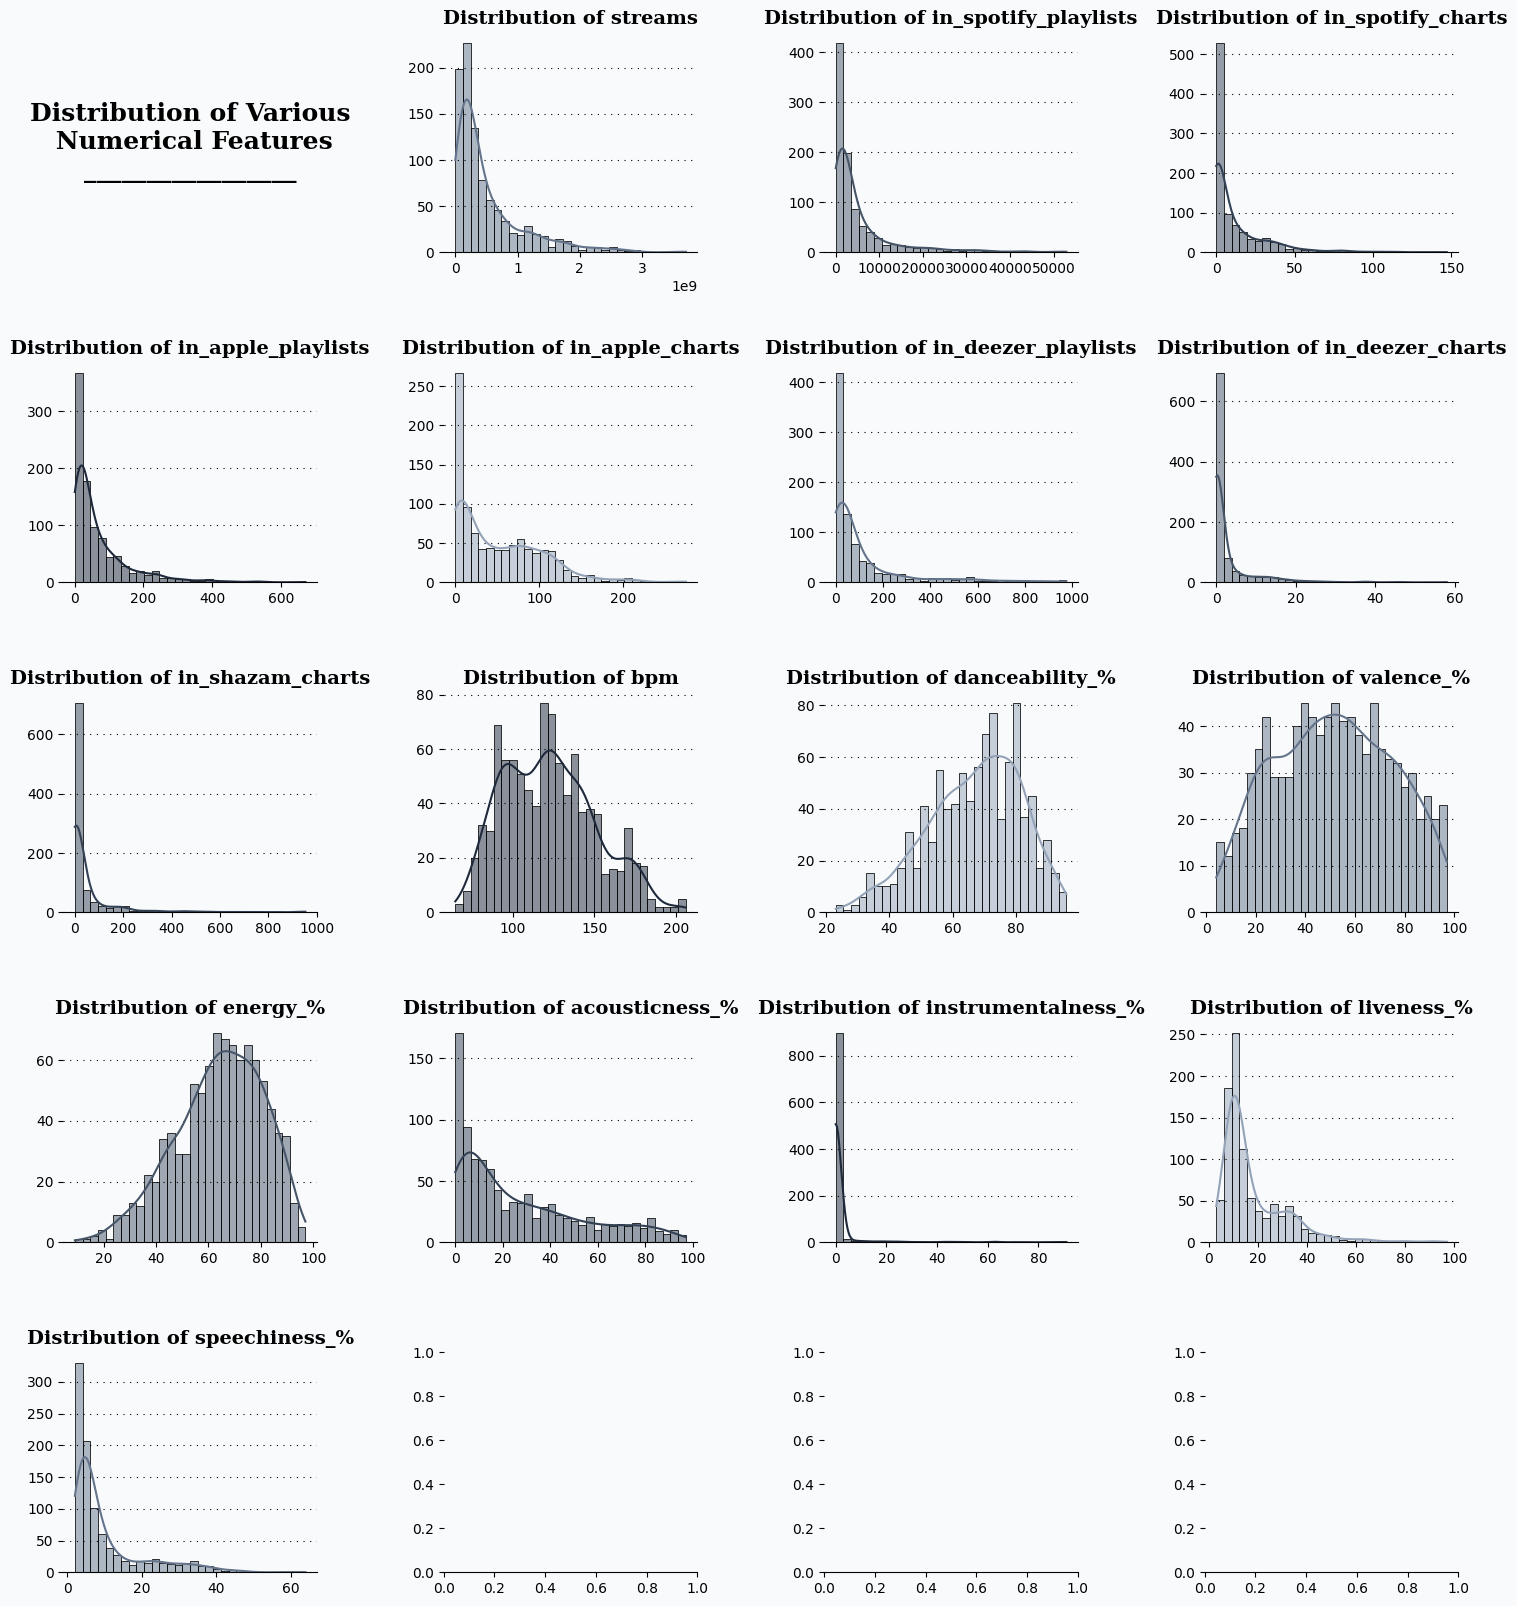

In [11]:
# Plot distributions for numerical features
fig = plt.figure(figsize=(18,20))
gs = fig.add_gridspec(5, 4)
gs.update(wspace=0.5, hspace=0.5)
axes = []

background_color = "#f8fafc"
color_palette = ["#94a3b8", "#64748b", "#475569", "#334155", "#1e293b"]
fig.patch.set_facecolor(background_color)

for i in range(5):
    for j in range(4):
        axes.append(fig.add_subplot(gs[i, j]))

for ax in axes:
    ax.set_facecolor(background_color)

# Title of the plot
axes[0].spines["bottom"].set_visible(False)
axes[0].spines["left"].set_visible(False)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].tick_params(left=False, bottom=False)
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].text(0.5, 0.5,
             'Distribution of Various\n Numerical Features\n_________________',
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=18, fontweight='bold',
             fontfamily='serif',
             color="#000000")

numerical_columns = ['streams', 'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts',
                     'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm', 'danceability_%', 'valence_%',
                     'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']

for i, col in enumerate(numerical_columns, 1):
    ax = axes[i]
    sns.histplot(data[col], kde=True, bins=30, ax=ax, color=color_palette[i % len(color_palette)])
    ax.set_title(f'Distribution of {col}', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
    ax.grid(color='#000000', linestyle=':', axis='y', zorder=0, dashes=(1, 5))
    ax.set_xlabel("")
    ax.set_ylabel("")

for ax in axes[1:]:
    for s in ["top", "right", "left"]:
        ax.spines[s].set_visible(False)

plt.tight_layout()
plt.show()

<ipython-input-12-809d92f4950d>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, order=data[col].value_counts().index, ax=ax, palette=color_palette)
<ipython-input-12-809d92f4950d>:38: UserWarning: 
The palette list has fewer values (5) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=data, x=col, order=data[col].value_counts().index, ax=ax, palette=color_palette)
<ipython-input-12-809d92f4950d>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, order=data[col].value_counts().index, ax=ax, palette=color_palette)
<ipython-input-12-809d92f4950d>:38: UserWarning: 
The palette list has fewer values (5) than 

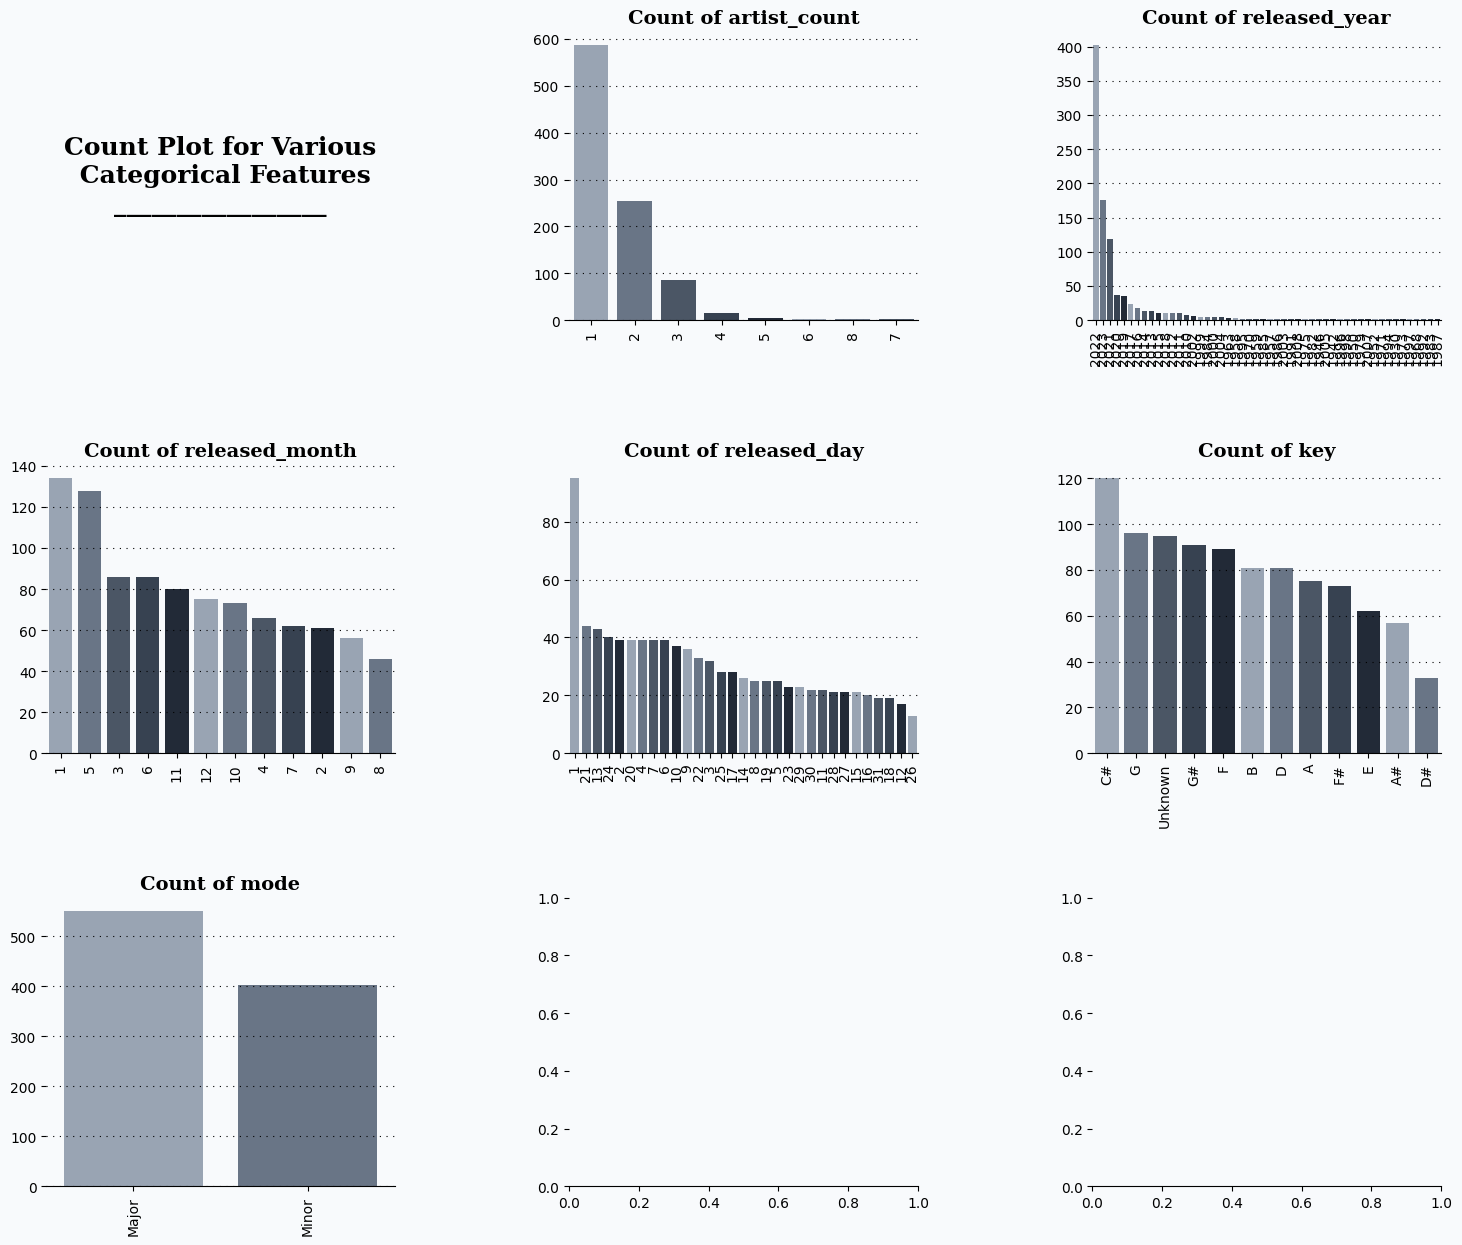

In [12]:
# Plot counts for categorical features
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.5, hspace=0.5)
axes = []

background_color = "#f8fafc"
color_palette = ["#94a3b8", "#64748b", "#475569", "#334155", "#1e293b"]
fig.patch.set_facecolor(background_color)

for i in range(3):
    for j in range(3):
        axes.append(fig.add_subplot(gs[i, j]))

for ax in axes:
    ax.set_facecolor(background_color)

# Title of the plot
axes[0].spines["bottom"].set_visible(False)
axes[0].spines["left"].set_visible(False)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].tick_params(left=False, bottom=False)
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].text(0.5, 0.5,
             'Count Plot for Various\n Categorical Features\n_________________',
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=18, fontweight='bold',
             fontfamily='serif',
             color="#000000")

categorical_columns = ['artist_count', 'released_year', 'released_month', 'released_day', 'key', 'mode']

for i, col in enumerate(categorical_columns, 1):
    ax = axes[i]
    sns.countplot(data=data, x=col, order=data[col].value_counts().index, ax=ax, palette=color_palette)
    ax.set_title(f'Count of {col}', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
    ax.grid(color='#000000', linestyle=':', axis='y', zorder=0, dashes=(1, 5))
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=90)

for ax in axes[1:]:
    for s in ["top", "right", "left"]:
        ax.spines[s].set_visible(False)

plt.tight_layout()
plt.show()


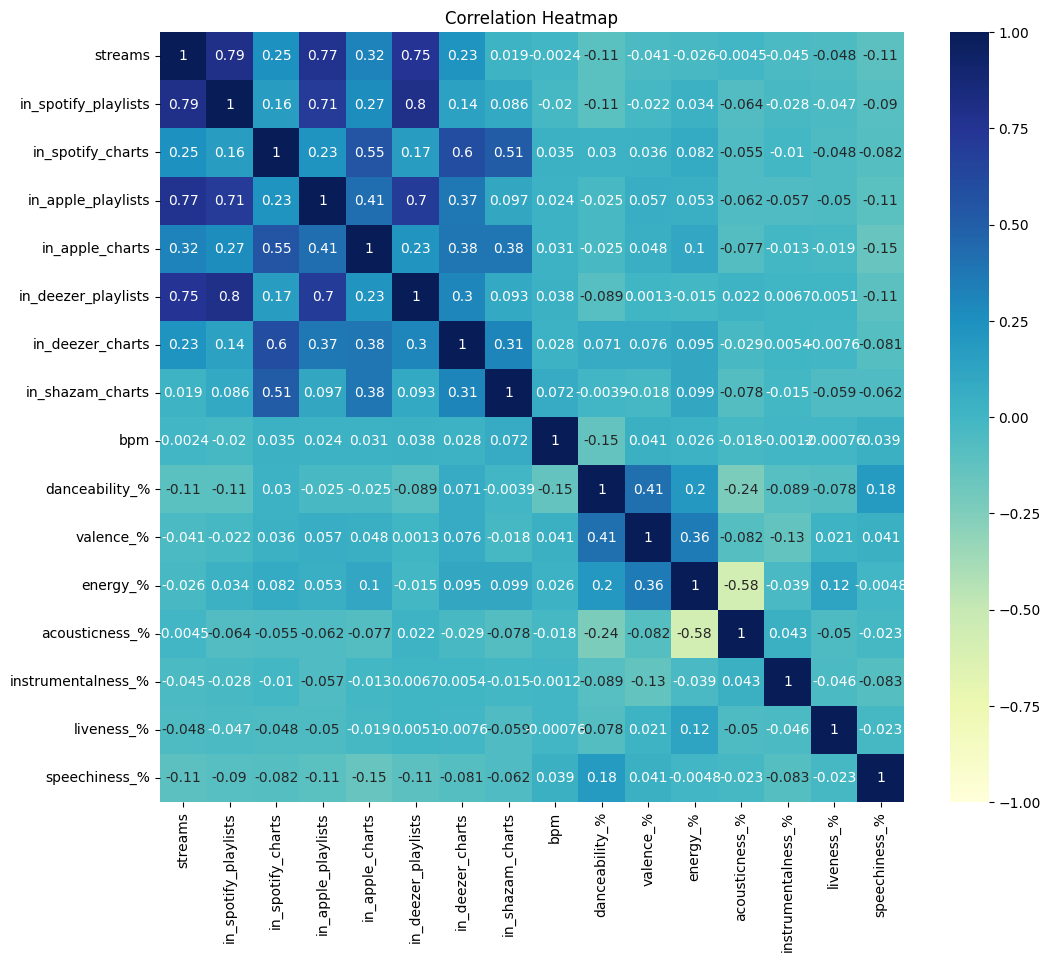

In [13]:
# Filter DataFrame by numerical columns
numeric_data = data[numerical_columns]

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = numeric_data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Features for clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


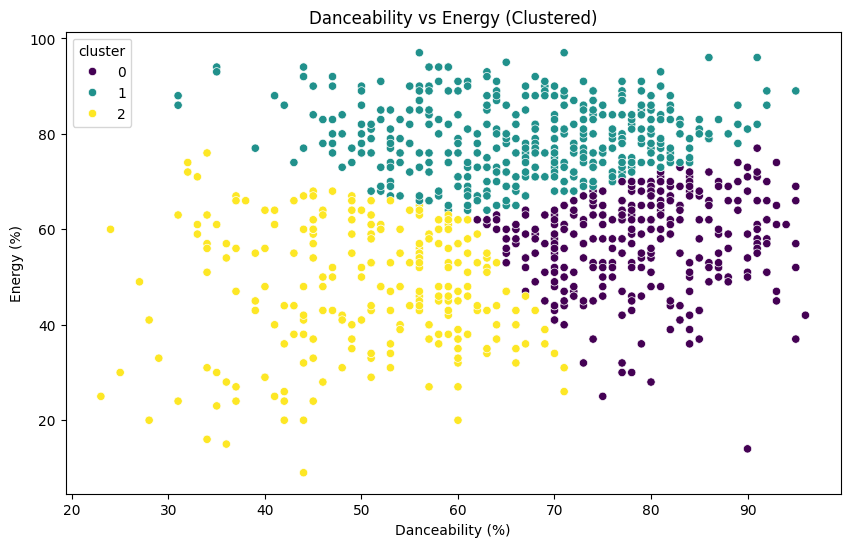

In [14]:
X = data[['danceability_%', 'energy_%']]
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='danceability_%', y='energy_%', data=data, hue='cluster', palette='viridis')
plt.title('Danceability vs Energy (Clustered)')
plt.xlabel('Danceability (%)')
plt.ylabel('Energy (%)')
plt.show()

### Cluster 0 (Purple):

- This cluster primarily occupies the lower range of danceability (30-70%) and energy (20-60%).
- Songs in this cluster tend to have lower energy and lower danceability. These could be more relaxed or mellow tracks, possibly including ballads or slower songs.

### Cluster 1 (Teal):

- This cluster occupies a higher range of energy (60-100%) and a mid to high range of danceability (50-80%).
- Songs in this cluster are characterized by high energy and moderate to high danceability. These could be upbeat tracks suitable for dancing, possibly including pop or dance tracks.

### Cluster 2 (Yellow):

- This cluster occupies a range with moderate to high energy (40-90%) and high danceability (60-90%).
- Songs in this cluster tend to be highly danceable with a moderate to high level of energy.
- These tracks are likely very rhythmic and could include genres like EDM, hip-hop, or electronic dance music.

# Artist Analysis:

artist(s)_name
Taylor Swift        29
The Weeknd          21
SZA                 19
Bad Bunny           19
Harry Styles        17
Kendrick Lamar      12
Morgan Wallen       11
Drake, 21 Savage     8
Feid                 8
BTS                  8
Name: count, dtype: int64


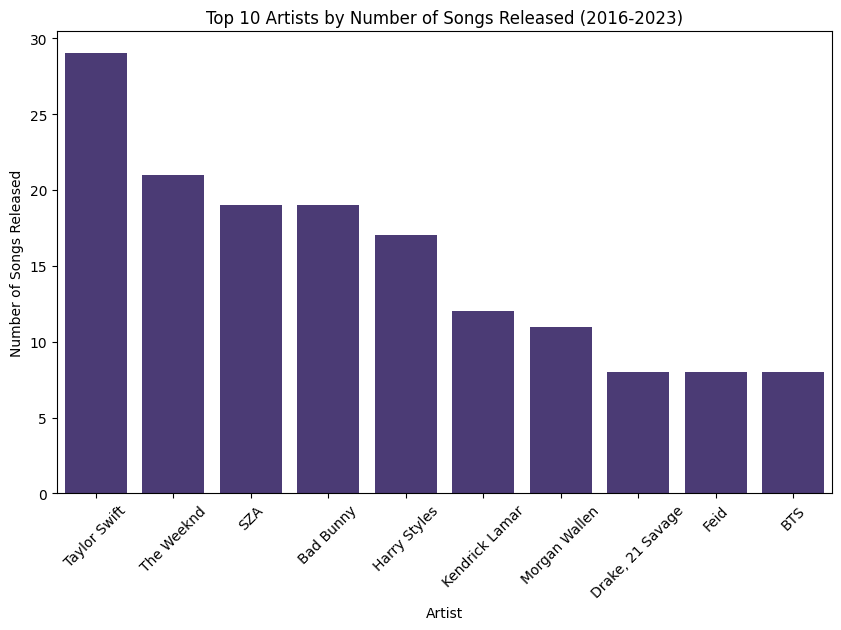

In [15]:
# Data filtering
recent_years = data[data['released_year'] > 2015]
top_artists = recent_years['artist(s)_name'].value_counts().head(10)
print(top_artists)

# Plotting
plt.figure(figsize=(10, 6))
sns.set_palette("viridis")
sns.barplot(x=top_artists.index, y=top_artists.values)
plt.title('Top 10 Artists by Number of Songs Released (2016-2023)')
plt.xlabel('Artist')
plt.ylabel('Number of Songs Released')
plt.xticks(rotation=45)
plt.show()

## Analysis of Top Artists by Number of Songs Released (2016-2023)

1. **Taylor Swift (29 songs):**
   - Taylor Swift tops the list with the highest number of songs released during the analyzed period. This highlights her prolific career as a singer-songwriter and her ability to maintain a constant presence in the music industry.

2. **The Weeknd (21 songs):**
   - The Weeknd takes the second spot with a significant number of songs released. His presence on the list underscores his ongoing success and his ability to produce music that resonates with audiences.

3. **SZA (19 songs) and Bad Bunny (19 songs):**
   - SZA and Bad Bunny are tied for the third spot with 19 songs each. This reflects their popularity and influence in the contemporary music scene, both nationally and internationally.

4. **Harry Styles (17 songs):**
   - Harry Styles closely follows in the fourth spot with a considerable number of songs released. His successful transition from boy band to solo artist has been well-received by critics and fans alike.

5. **Diversity of Genres and Styles:**
   - The list includes a variety of musical genres, from pop and R&B to rap and reggaetón. This reflects the diversity of audience tastes and the eclectic nature of the current music industry.

6. **Presence of Rap and Hip-Hop:**
   - Artists like Kendrick Lamar, Drake, and 21 Savage represent the continued influence of rap and hip-hop in contemporary music. Their inclusion in the list highlights their relevance and popularity within the genre.

7. **International Presence:**
   - The presence of artists such as Bad Bunny, Feid, and BTS showcases the importance of Latin music and K-pop in the global music landscape. These artists have achieved significant success both in their respective markets and internationally.

In summary, this list of the top ten artists by the number of songs released provides an insightful view of the dynamics of the music industry during the analyzed period, highlighting the diversity of genres, styles, and the presence of both established and emerging artists.

# Top Streamed Songs

In [16]:
top_streamed_songs = data.sort_values(by='streams', ascending=False).head(10)
print(top_streamed_songs[['track_name', 'artist(s)_name', 'streams']])

                                        track_name  \
55                                 Blinding Lights   
179                                   Shape of You   
86                               Someone You Loved   
620                                   Dance Monkey   
41   Sunflower - Spider-Man: Into the Spider-Verse   
162                                      One Dance   
84                       STAY (with Justin Bieber)   
140                                       Believer   
725                                         Closer   
48                                         Starboy   

                   artist(s)_name       streams  
55                     The Weeknd  3.703895e+09  
179                    Ed Sheeran  3.562544e+09  
86                  Lewis Capaldi  2.887242e+09  
620                   Tones and I  2.864792e+09  
41          Post Malone, Swae Lee  2.808097e+09  
162           Drake, WizKid, Kyla  2.713922e+09  
84   Justin Bieber, The Kid Laroi  2.665344e+09  
140  

## Analysis of Top Streamed Songs

This output presents a list of the 10 most streamed songs in the dataset, along with their respective artists and the number of streams they have accumulated. Here are some points of analysis and curiosities based on this information:

1. **Popularity of "Blinding Lights":**
   - "Blinding Lights" by The Weeknd is the most streamed song, with nearly 3.7 billion streams. This song has been a global phenomenon and has remained on the charts for a long time.

2. **Dominance of "Shape of You":**
   - "Shape of You" by Ed Sheeran ranks second, with over 3.5 billion streams. This song was a massive hit and is one of the most popular songs of the last decade.

3. **Diversity of Artists:**
   - The list includes a variety of artists and genres, from pop and rock to R&B and electronic music. This reflects the diversity of musical tastes among the public on streaming platforms.

4. **Successful Collaborations:**
   - Several songs on the list are collaborations between artists. For example, "Sunflower" is a collaboration between Post Malone and Swae Lee, while "One Dance" features Drake, WizKid, and Kyla. Collaborations tend to attract fans of multiple artists, which can significantly increase the number of streams.

5. **Repetition of The Weeknd:**
   - The Weeknd appears twice on the list, with both "Blinding Lights" and "Starboy" (featuring Daft Punk). This highlights his ability to consistently produce hits that resonate with a broad audience.

6. **Impact of Soundtracks:**
   - "Sunflower" is part of the soundtrack for the movie "Spider-Man: Into the Spider-Verse." Songs associated with popular movies often receive an additional boost in popularity and streams.

7. **Success of Emerging Artists:**
   - "STAY" by The Kid Laroi (with Justin Bieber) and "Dance Monkey" by Tones and I are examples of how relatively new artists can achieve massive success on streaming platforms.

8. **Presence of Imagine Dragons and The Chainsmokers:**
   - Imagine Dragons with "Believer" and The Chainsmokers with "Closer" (featuring Halsey) show how these bands have maintained a dominant presence in pop and electronic music.

9. **Number of Streams:**
   - All the songs on the list have more than 2.5 billion streams, demonstrating the enormous popularity and global reach of these tracks.

This analysis highlights how certain artists and songs can dominate the global music streaming landscape, and how strategic collaborations and associations can significantly contribute to a song's success.


# Seasonal Analysis

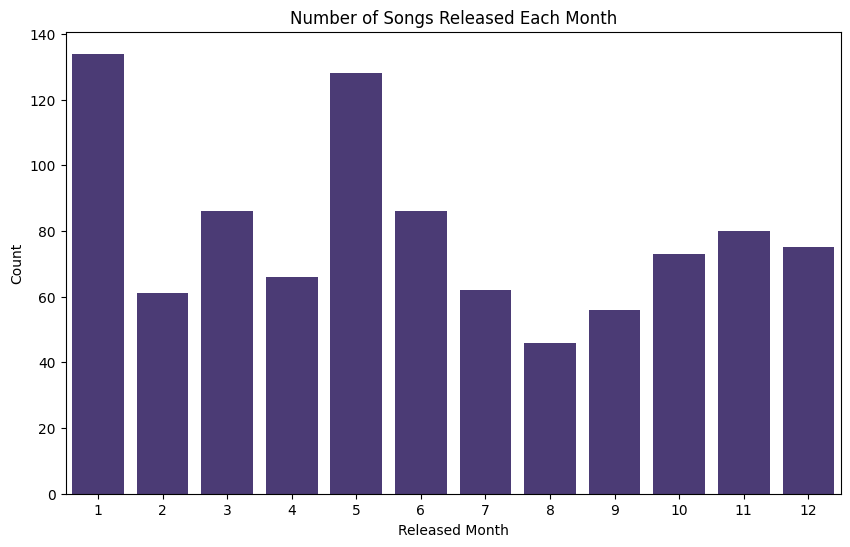

In [17]:
plt.figure(figsize=(10, 6))
sns.set_palette("viridis")
sns.countplot(x='released_month', data=data)
plt.title('Number of Songs Released Each Month')
plt.xlabel('Released Month')
plt.ylabel('Count')
plt.show()

## Analysis of Songs Released by Month

1. **January (134 songs):**
   - January emerges as the month with the highest number of song releases. This could be attributed to artists and record labels starting the year with new music releases, aiming to capitalize on the fresh start and potential for increased listener engagement.

2. **May (128 songs):**
   - May follows closely behind January in terms of song releases. This could be influenced by the lead-up to the summer months, which are often associated with increased music consumption due to vacations, outdoor events, and festivals.

3. **March (86 songs) and June (86 songs):**
   - March and June tie for the third position with a similar number of song releases. March may see a surge in releases as artists prepare for spring tours and promotions, while June marks the beginning of the summer season, prompting artists to release music suitable for the warmer weather.

4. **November (80 songs):**
   - November ranks fifth in terms of song releases. This could be attributed to artists gearing up for the holiday season, as well as the timing of award shows and end-of-year music releases.

5. **December (75 songs):**
   - December sees a significant number of song releases, likely driven by the holiday season and artists aiming to capitalize on the festive atmosphere with new music.

6. **October (73 songs):**
   - October ranks slightly lower in terms of song releases. However, it still sees a substantial number of releases, possibly due to artists vying for attention before the holiday season kicks in.

7. **April (66 songs):**
   - April ranks lower compared to the preceding months in terms of song releases. This could be influenced by factors such as artists focusing on tour preparations or strategic timing to avoid competition from major releases.

8. **July (62 songs):**
   - July sees a moderate number of song releases. This could be attributed to artists taking advantage of the summer months to release music suited for vacations and outdoor activities.

9. **February (61 songs):**
   - February ranks lower in terms of song releases compared to other months. This could be influenced by factors such as the post-holiday season lull and artists focusing on promotional activities rather than new releases.

10. **September (56 songs):**
    - September sees a relatively lower number of song releases compared to other months. This could be attributed to artists preparing for the end-of-year rush or strategically timing releases for maximum impact.

11. **August (46 songs):**
    - August ranks lowest in terms of song releases. This could be influenced by factors such as the summer slowdown in the music industry, with artists and labels focusing on tour engagements or planning for upcoming releases.
